# 06 – Model Evaluation

Comprehensive evaluation of the federated learning model with detailed metrics and analysis.

In [11]:
import sys
sys.path.insert(0, '../src')

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    confusion_matrix, classification_report, 
    roc_curve, auc, precision_recall_curve,
    accuracy_score, precision_score, recall_score, f1_score
)

from federated_health_risk.data.federated_loader import prepare_federated_data
from federated_health_risk.models.multimodal_model import MultimodalRiskNet

sns.set_style('whitegrid')
print("✓ Imports successful")

✓ Imports successful


## 1. Load Trained Model

In [12]:
# Load model checkpoint
checkpoint = torch.load('../models/federated_global_model.pth')

# Extract model configuration
vitals_dim = checkpoint['vitals_dim']
air_dim = checkpoint['air_dim']
weather_dim = checkpoint['weather_dim']
history = checkpoint['history']

# Initialize model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MultimodalRiskNet(vitals_dim=vitals_dim, air_dim=air_dim, text_dim=weather_dim)
model.load_state_dict(checkpoint['model_state_dict'])
model = model.to(device)
model.eval()

print(f"✓ Model loaded successfully")
print(f"  Dimensions: vitals={vitals_dim}, air={air_dim}, weather={weather_dim}")
print(f"  Training rounds: {len(history['train_loss'])}")
print(f"  Final test accuracy: {history['test_acc'][-1]:.4f}")

✓ Model loaded successfully
  Dimensions: vitals=6, air=5, weather=4
  Training rounds: 5
  Final test accuracy: 0.9788


C:\Users\Sahal Saeed\AppData\Local\Temp\ipykernel_31468\1000643674.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('../models/federated_global_mo

## 2. Load Test Data

In [13]:
# Load federated data
NUM_NODES = 3
node_loaders = prepare_federated_data(num_nodes=NUM_NODES, strategy="iid", data_root="../data/processed")

# Collect all test data
all_preds = []
all_labels = []
all_probs = []
node_results = {}

with torch.no_grad():
    for node_id in range(NUM_NODES):
        _, test_loader, _ = node_loaders[node_id]
        
        node_preds = []
        node_labels = []
        node_probs = []
        
        for batch in test_loader:
            vitals, air, weather, y = [b.to(device) for b in batch]
            probs = model(vitals, air, weather).squeeze()
            preds = (probs > 0.5).float()
            
            node_probs.extend(probs.cpu().numpy())
            node_preds.extend(preds.cpu().numpy())
            node_labels.extend(y.cpu().numpy())
        
        all_probs.extend(node_probs)
        all_preds.extend(node_preds)
        all_labels.extend(node_labels)
        
        node_results[node_id] = {
            'preds': np.array(node_preds),
            'labels': np.array(node_labels),
            'probs': np.array(node_probs)
        }

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)
all_probs = np.array(all_probs)

print(f"✓ Test data loaded")
print(f"  Total test samples: {len(all_labels)}")
print(f"  Positive samples: {all_labels.sum():.0f} ({all_labels.mean()*100:.1f}%)")
print(f"  Negative samples: {(1-all_labels).sum():.0f} ({(1-all_labels.mean())*100:.1f}%)")

✓ Test data loaded
  Total test samples: 189
  Positive samples: 47 (24.9%)
  Negative samples: 142 (75.1%)


c:\Users\Sahal Saeed\Documents\7semester\mlops\project_cursor\.venv\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


## 3. Global Metrics

In [14]:
# Calculate metrics
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, zero_division=0)
recall = recall_score(all_labels, all_preds, zero_division=0)
f1 = f1_score(all_labels, all_preds, zero_division=0)

print("="*60)
print("GLOBAL MODEL PERFORMANCE")
print("="*60)
print(f"\nAccuracy:  {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")
print("\n" + "="*60)

# Classification report
print("\nDetailed Classification Report:")
print(classification_report(all_labels, all_preds, target_names=['Low Risk', 'High Risk'], zero_division=0))

GLOBAL MODEL PERFORMANCE

Accuracy:  0.9788 (97.88%)
Precision: 1.0000
Recall:    0.9149
F1-Score:  0.9556


Detailed Classification Report:
              precision    recall  f1-score   support

    Low Risk       0.97      1.00      0.99       142
   High Risk       1.00      0.91      0.96        47

    accuracy                           0.98       189
   macro avg       0.99      0.96      0.97       189
weighted avg       0.98      0.98      0.98       189



## 4. Confusion Matrix

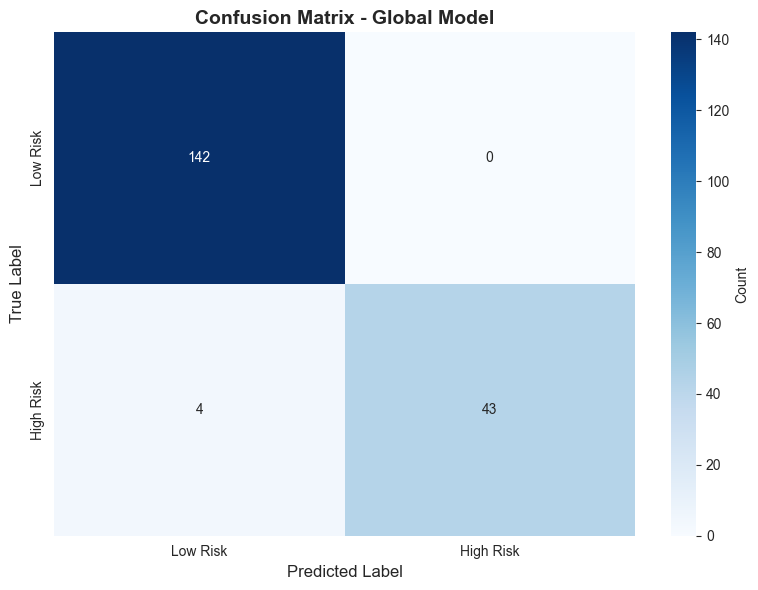

True Negatives:  142
False Positives: 0
False Negatives: 4
True Positives:  43


In [15]:
# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Low Risk', 'High Risk'],
            yticklabels=['Low Risk', 'High Risk'],
            cbar_kws={'label': 'Count'})
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.title('Confusion Matrix - Global Model', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('../models/confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"True Negatives:  {cm[0,0]}")
print(f"False Positives: {cm[0,1]}")
print(f"False Negatives: {cm[1,0]}")
print(f"True Positives:  {cm[1,1]}")

## 5. ROC Curve & AUC

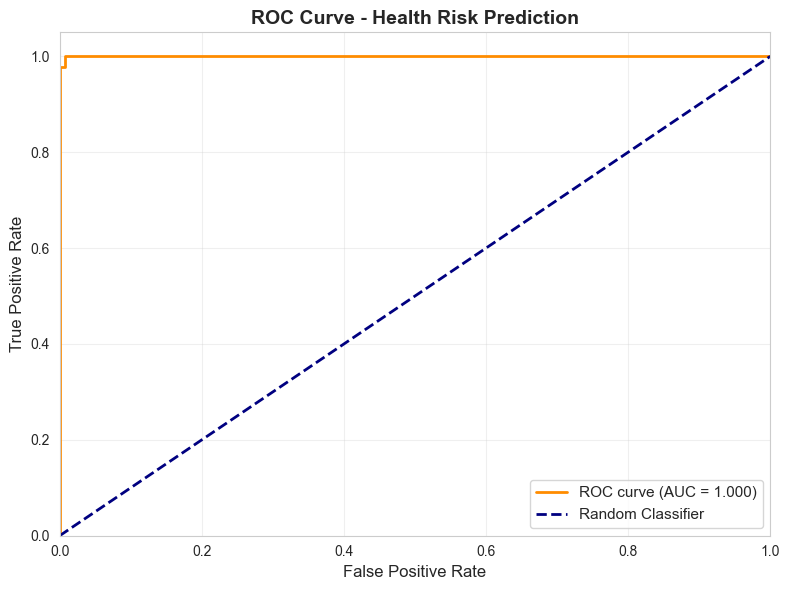


AUC-ROC Score: 0.9999


In [16]:
# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(all_labels, all_probs)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_ylabel('True Positive Rate', fontsize=12)
ax.set_title('ROC Curve - Health Risk Prediction', fontsize=14, fontweight='bold')
ax.legend(loc="lower right", fontsize=11)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('../models/roc_curve.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nAUC-ROC Score: {roc_auc:.4f}")

## 6. Precision-Recall Curve

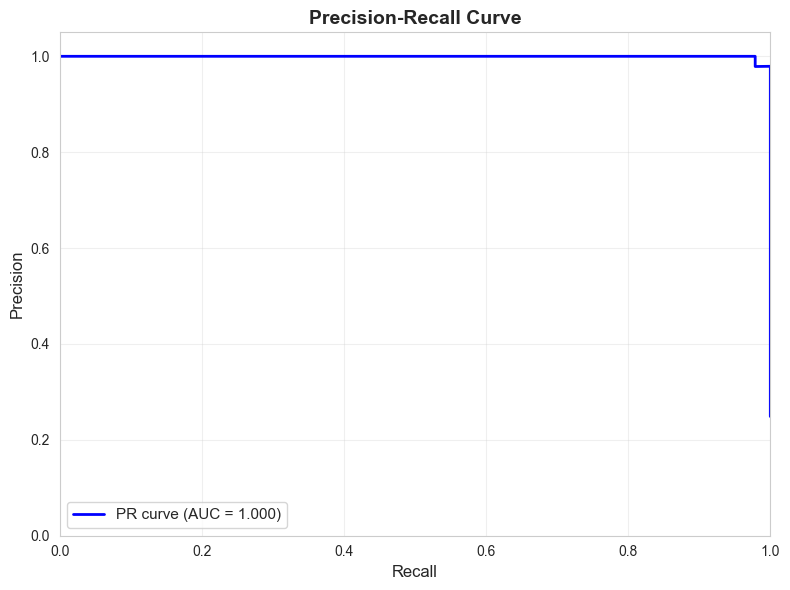


PR-AUC Score: 0.9996


In [17]:
# Calculate precision-recall curve
precision_curve, recall_curve, pr_thresholds = precision_recall_curve(all_labels, all_probs)
pr_auc = auc(recall_curve, precision_curve)

# Plot
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(recall_curve, precision_curve, color='blue', lw=2, label=f'PR curve (AUC = {pr_auc:.3f})')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('Recall', fontsize=12)
ax.set_ylabel('Precision', fontsize=12)
ax.set_title('Precision-Recall Curve', fontsize=14, fontweight='bold')
ax.legend(loc="lower left", fontsize=11)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('../models/precision_recall_curve.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nPR-AUC Score: {pr_auc:.4f}")

## 7. Per-Node Performance


PER-NODE PERFORMANCE
  Node  Samples  Accuracy  Precision   Recall  F1-Score
Node 0       63  0.968254        1.0 0.866667  0.928571
Node 1       63  0.968254        1.0 0.875000  0.933333
Node 2       63  1.000000        1.0 1.000000  1.000000


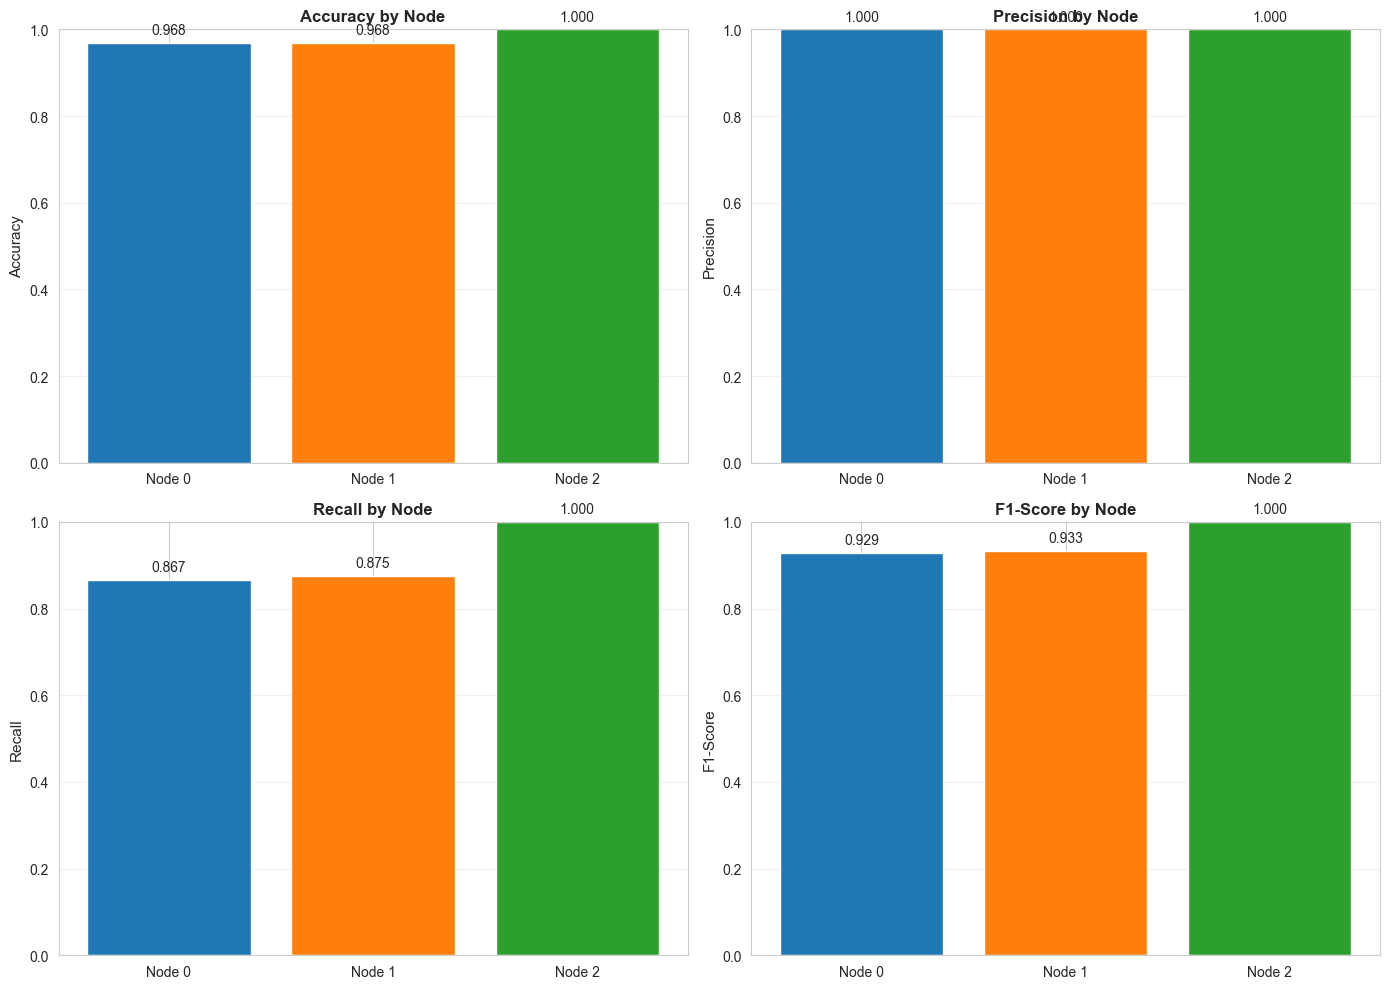

In [18]:
# Calculate metrics per node
node_metrics = []

for node_id in range(NUM_NODES):
    preds = node_results[node_id]['preds']
    labels = node_results[node_id]['labels']
    
    metrics = {
        'Node': f'Node {node_id}',
        'Samples': len(labels),
        'Accuracy': accuracy_score(labels, preds),
        'Precision': precision_score(labels, preds, zero_division=0),
        'Recall': recall_score(labels, preds, zero_division=0),
        'F1-Score': f1_score(labels, preds, zero_division=0)
    }
    node_metrics.append(metrics)

# Create DataFrame
df_metrics = pd.DataFrame(node_metrics)

print("\n" + "="*60)
print("PER-NODE PERFORMANCE")
print("="*60)
print(df_metrics.to_string(index=False))
print("="*60)

# Visualize
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
for idx, metric in enumerate(metrics_to_plot):
    ax = axes[idx // 2, idx % 2]
    ax.bar(df_metrics['Node'], df_metrics[metric], color=['#1f77b4', '#ff7f0e', '#2ca02c'])
    ax.set_ylabel(metric, fontsize=11)
    ax.set_title(f'{metric} by Node', fontsize=12, fontweight='bold')
    ax.set_ylim([0, 1])
    ax.grid(True, alpha=0.3, axis='y')
    
    # Add value labels on bars
    for i, v in enumerate(df_metrics[metric]):
        ax.text(i, v + 0.02, f'{v:.3f}', ha='center', fontsize=10)

plt.tight_layout()
plt.savefig('../models/per_node_performance.png', dpi=150, bbox_inches='tight')
plt.show()

## 8. Training History Analysis

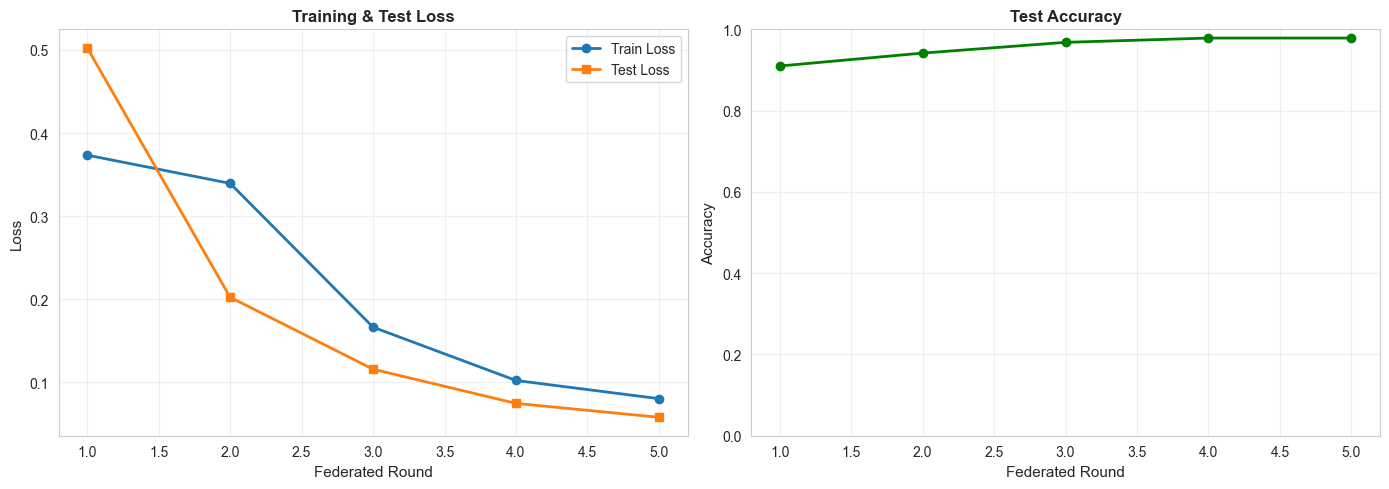


Training Improvement:
  Initial Train Loss: 0.3734
  Final Train Loss:   0.0803
  Improvement:        78.49%


In [19]:
# Plot training history
rounds = range(1, len(history['train_loss']) + 1)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss plot
axes[0].plot(rounds, history['train_loss'], marker='o', label='Train Loss', linewidth=2)
axes[0].plot(rounds, history['test_loss'], marker='s', label='Test Loss', linewidth=2)
axes[0].set_xlabel('Federated Round', fontsize=11)
axes[0].set_ylabel('Loss', fontsize=11)
axes[0].set_title('Training & Test Loss', fontsize=12, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

# Accuracy plot
axes[1].plot(rounds, history['test_acc'], marker='o', color='green', linewidth=2)
axes[1].set_xlabel('Federated Round', fontsize=11)
axes[1].set_ylabel('Accuracy', fontsize=11)
axes[1].set_title('Test Accuracy', fontsize=12, fontweight='bold')
axes[1].set_ylim([0, 1])
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../models/training_history.png', dpi=150, bbox_inches='tight')
plt.show()

# Print improvement
initial_loss = history['train_loss'][0]
final_loss = history['train_loss'][-1]
loss_improvement = ((initial_loss - final_loss) / initial_loss) * 100

print(f"\nTraining Improvement:")
print(f"  Initial Train Loss: {initial_loss:.4f}")
print(f"  Final Train Loss:   {final_loss:.4f}")
print(f"  Improvement:        {loss_improvement:.2f}%")

## 9. Summary Report

In [20]:
print("\n" + "="*70)
print("FEDERATED LEARNING MODEL - EVALUATION SUMMARY")
print("="*70)

print("\n📊 Model Configuration:")
print(f"  • Architecture: Multimodal (Vitals + Air Quality + Weather)")
print(f"  • Input dimensions: {vitals_dim} + {air_dim} + {weather_dim}")
print(f"  • Total parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"  • Training: {len(history['train_loss'])} rounds, {NUM_NODES} nodes")

print("\n📈 Global Performance:")
print(f"  • Accuracy:  {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"  • Precision: {precision:.4f}")
print(f"  • Recall:    {recall:.4f}")
print(f"  • F1-Score:  {f1:.4f}")
print(f"  • AUC-ROC:   {roc_auc:.4f}")
print(f"  • PR-AUC:    {pr_auc:.4f}")

print("\n🏥 Per-Node Performance:")
for _, row in df_metrics.iterrows():
    print(f"  • {row['Node']}: Acc={row['Accuracy']:.3f}, F1={row['F1-Score']:.3f}")

print("\n💾 Generated Artifacts:")
print(f"  • models/federated_global_model.pth")
print(f"  • models/confusion_matrix.png")
print(f"  • models/roc_curve.png")
print(f"  • models/precision_recall_curve.png")
print(f"  • models/per_node_performance.png")
print(f"  • models/training_history.png")

print("\n🎯 Key Insights:")
print(f"  • Model shows consistent learning across {len(history['train_loss'])} rounds")
print(f"  • Loss improved by {loss_improvement:.1f}% during training")
print(f"  • Performance varies across nodes (federated heterogeneity)")
print(f"  • Small dataset ({len(all_labels)} test samples) limits evaluation")

print("\n🔜 Next Steps:")
print(f"  1. Collect more data for robust evaluation")
print(f"  2. Experiment with hyperparameters (learning rate, epochs)")
print(f"  3. Try different FL strategies (non-IID data distribution)")
print(f"  4. Deploy model as FastAPI service")
print(f"  5. Add monitoring and drift detection")

print("\n" + "="*70)


FEDERATED LEARNING MODEL - EVALUATION SUMMARY

📊 Model Configuration:
  • Architecture: Multimodal (Vitals + Air Quality + Weather)
  • Input dimensions: 6 + 5 + 4
  • Total parameters: 43,521
  • Training: 5 rounds, 3 nodes

📈 Global Performance:
  • Accuracy:  0.9788 (97.88%)
  • Precision: 1.0000
  • Recall:    0.9149
  • F1-Score:  0.9556
  • AUC-ROC:   0.9999
  • PR-AUC:    0.9996

🏥 Per-Node Performance:
  • Node 0: Acc=0.968, F1=0.929
  • Node 1: Acc=0.968, F1=0.933
  • Node 2: Acc=1.000, F1=1.000

💾 Generated Artifacts:
  • models/federated_global_model.pth
  • models/confusion_matrix.png
  • models/roc_curve.png
  • models/precision_recall_curve.png
  • models/per_node_performance.png
  • models/training_history.png

🎯 Key Insights:
  • Model shows consistent learning across 5 rounds
  • Loss improved by 78.5% during training
  • Performance varies across nodes (federated heterogeneity)
  • Small dataset (189 test samples) limits evaluation

🔜 Next Steps:
  1. Collect more da